# Logistic Regression - From Scratch


In [2]:
# Imports & setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# Sklearn Library Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as SkLogReg
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

np.random.seed(42)

# Matplotlib Defaults
plt.rcParams["figure.figsize"] = (7.5, 5.0)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11

## Problem 4 - Objective (Loss) Function (with L2)


## Problems 1-4 --- ScratchLogisticRegression Class

Notes:
- Training and validation losses are recorded per iteration.
- If `verbose=True`, print training progress periodically.

We support **L2 regularization** with parameter `reg_lambda`. Set `use_bias=False` to remove the intercept entirely.

In [3]:
class ScratchLogisticRegression:
    """
    Scratch implementation of Logistic Regression (binary) with batch Gradient Descent and optional L2 regularization.

    Parameters
    ----------
    num_iter : int
        Number of iterations (epochs) for gradient descent.
    lr : float
        Learning rate.
    reg_lambda : float
        L2 regularization strength (λ). Set 0.0 to disable.
    use_bias : bool
        If True, include an intercept term (x0=1). If False, no intercept.
    verbose : bool
        If True, print training progress periodically.

    Attributes
    ----------
    coef_ : ndarray of shape (n_features,)
        Learned weights (excluding intercept).
    intercept_ : float
        Learned bias (0.0 if use_bias=False).
    theta_ : ndarray of shape (n_features + 1) if use_bias else (n_features,)
        Full parameter vector used internally.
    loss : ndarray of shape (num_iter,)
        Training loss per iteration (regularized logistic loss).
    val_loss : ndarray of shape (num_iter,)
        Validation loss per iteration (if validation data is provided).
    """

    def __init__(self, num_iter=800, lr=0.1, reg_lambda=0.0, use_bias=True, verbose=False, bias=None):
        # Support template's 'bias' name if provided; otherwise use 'use_bias'
        if bias is not None:
            use_bias = bool(bias)
        self.iter = int(num_iter)
        self.lr = float(lr)
        self.reg_lambda = float(reg_lambda)
        self.use_bias = bool(use_bias)
        self.bias = self.use_bias  # alias for template compatibility
        self.verbose = bool(verbose)

        # Loss trackers
        self.loss = np.zeros(self.iter, dtype=float)
        self.val_loss = np.zeros(self.iter, dtype=float)

        # Params
        self.theta_ = None
        self.coef_ = None
        self.intercept_ = 0.0

    # Utilities
    def _maybe_add_bias(self, X: np.ndarray) -> np.ndarray:
        """Add bias column if use_bias=True; otherwise return X unchanged."""
        if self.use_bias:
            ones = np.ones((X.shape[0], 1), dtype=X.dtype)
            return np.hstack([ones, X])
        return X

    def _init_params(self, n_params: int):
        """Initialize parameters to zeros for stable start on convex loss."""
        self.theta_ = np.zeros(n_params, dtype=float)

    # Problem 1: Hypothesis (sigmoid of linear score)
    @staticmethod
    def _sigmoid(z: np.ndarray) -> np.ndarray:
        """Numerically-stable sigmoid σ(z) = 1 / (1 + exp(-z))."""
        # clip to avoid overflow
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))

    def _linear_hypothesis(self, X_aug: np.ndarray) -> np.ndarray:
        """Compute linear score: s = X_aug @ theta_."""
        return (X_aug @ self.theta_).reshape(-1)

    def _logistic_hypothesis(self, X_aug: np.ndarray) -> np.ndarray:
        """Compute logistic hypothesis h = σ(X_aug @ theta_)."""
        return self._sigmoid(self._linear_hypothesis(X_aug))

    # Problem 4: Objective (logistic loss)
    def _objective(self, y_hat: np.ndarray, y: np.ndarray) -> float:
        m = y.shape[0]
        eps = 1e-12
        y_hat = np.clip(y_hat, eps, 1 - eps)
        base = (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()
        if self.reg_lambda > 0.0:
            if self.use_bias:
                # exclude intercept (theta_[0])
                reg = (self.reg_lambda / (2 * m)) * np.sum(self.theta_[1:] ** 2)
            else:
                reg = (self.reg_lambda / (2 * m)) * np.sum(self.theta_ ** 2)
            return float(base + reg)
        return float(base)

    # Problem 2: Gradient Descent (with L2)
    def _gradient_descent(self, X_aug: np.ndarray, y: np.ndarray, y_hat: np.ndarray):
        """
        One batch GD step.
        Grad = (1/m) X^T (h - y) + (λ/m) * θ (excluding θ0 if intercept present).
        """
        m = y.shape[0]
        error = (y_hat - y).reshape(-1)  # shape (m,)
        grad = (X_aug.T @ error) / m      # shape (n_params,)

        if self.reg_lambda > 0.0:
            if self.use_bias:
                reg = (self.reg_lambda / m) * self.theta_.copy()
                reg[0] = 0.0  # do not regularize intercept
            else:
                reg = (self.reg_lambda / m) * self.theta_
            grad = grad + reg

        self.theta_ -= self.lr * grad

    # Fit/Predict
    def fit(self, X: np.ndarray, y: np.ndarray, X_val: np.ndarray = None, y_val: np.ndarray = None):
        """
        Train logistic regression. If validation data is provided, track its loss per iteration too.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Training features
        y : ndarray of shape (n_samples,)
            Training labels (0/1)
        X_val, y_val : optional validation set
        """
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).reshape(-1)
        X_aug = self._maybe_add_bias(X)
        self._init_params(X_aug.shape[1])

        for t in range(self.iter):
            y_hat = self._logistic_hypothesis(X_aug)
            self.loss[t] = self._objective(y_hat, y)

            # GD update
            self._gradient_descent(X_aug, y, y_hat)

            # Validation loss
            if X_val is not None and y_val is not None:
                Xv = np.asarray(X_val, dtype=float)
                yv = np.asarray(y_val, dtype=float).reshape(-1)
                Xv_aug = self._maybe_add_bias(Xv)
                yv_hat = self._logistic_hypothesis(Xv_aug)
                self.val_loss[t] = self._objective(yv_hat, yv)

            # Optional progress print
            if self.verbose and (t % max(1, self.iter // 10) == 0 or t == self.iter - 1):
                if X_val is not None and y_val is not None:
                    print(f"iter {t+1:4d}/{self.iter}  J_train={self.loss[t]:.6f}  J_val={self.val_loss[t]:.6f}")
                else:
                    print(f"iter {t+1:4d}/{self.iter}  J_train={self.loss[t]:.6f}")

        # Expose learned parameters
        if self.use_bias:
            self.intercept_ = float(self.theta_[0])
            self.coef_ = self.theta_[1:].copy()
        else:
            self.intercept_ = 0.0
            self.coef_ = self.theta_.copy()
        return self

    # Problem 3: predict_proba & predict
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Return class-1 probabilities P(y=1|x) as a 1-D array.
        """
        X = np.asarray(X, dtype=float)
        X_aug = self._maybe_add_bias(X)
        return self._logistic_hypothesis(X_aug)

    def predict(self, X: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        """
        Return class labels (0/1) by thresholding predict_proba at `threshold`.
        """
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)

    # Problem 8: Save/Load weights
    def save_weights(self, path: str):
        """
        Save learned parameters and meta to a .npz file.
        """
        meta = dict(
            use_bias=self.use_bias,
            lr=self.lr,
            num_iter=self.iter,
            reg_lambda=self.reg_lambda
        )
        np.savez(path, theta=self.theta_, meta=json.dumps(meta))

    @staticmethod
    def load_weights(path: str):
        """
        Load parameters & meta from .npz. Returns (theta, meta_dict).
        """
        data = np.load(path, allow_pickle=True)
        theta = data["theta"]
        meta = json.loads(str(data["meta"]))
        return theta, meta

## Problem 5 - Learning & Estimation on Iris (versicolor vs. virginica)

We use two Iris classes (label **1 = virginica**, **0 = versicolor**) for binary classification.  
Features are standardized to help convergence.

In [4]:
# Load / prepare Iris
def load_iris_binary():
    iris = datasets.load_iris()
    X = iris["data"]
    y = iris["target"]
    # Keep versicolor (1) and virginica (2)
    mask = (y != 0)
    X = X[mask]
    y = y[mask]
    # Relabel: versicolor -> 0, virginica -> 1
    y = (y == 2).astype(int)
    feature_names = iris["feature_names"]
    return X, y, feature_names

X_all, y_all, feature_names = load_iris_binary()

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.3, random_state=42, stratify=y_all)

# Standardize
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)

# Train scratch model
scratch = ScratchLogisticRegression(num_iter=800, lr=0.1, reg_lambda=0.1, use_bias=True, verbose=False)
scratch.fit(X_train_std, y_train, X_val=X_val_std, y_val=y_val)

# Evaluate scratch model
proba_val = scratch.predict_proba(X_val_std)
pred_val = scratch.predict(X_val_std)

def manual_accuracy(y_true, y_pred):
    y_true = y_true.reshape(-1); y_pred = y_pred.reshape(-1)
    return float((y_true == y_pred).mean())

def manual_precision(y_true, y_pred):
    y_true = y_true.reshape(-1); y_pred = y_pred.reshape(-1)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return float(tp / (tp + fp + 1e-12))

def manual_recall(y_true, y_pred):
    y_true = y_true.reshape(-1); y_pred = y_pred.reshape(-1)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return float(tp / (tp + fn + 1e-12))

acc = accuracy_score(y_val, pred_val)
prec = precision_score(y_val, pred_val)
rec = recall_score(y_val, pred_val)
cm = confusion_matrix(y_val, pred_val)

print("Scratch Logistic Regression (Validation)")
print("  Accuracy :", f"{acc:.4f}")
print("  Precision:", f"{prec:.4f}")
print("  Recall   :", f"{rec:.4f}")
print("Confusion Matrix:\n", cm)

# Baseline: scikit-learn logistic regression for comparison
sk = SkLogReg(C=1e6, penalty="l2", solver="lbfgs", max_iter=1000)  # C large ~ weak regularization
sk.fit(X_train_std, y_train)
pred_val_sk = sk.predict(X_val_std)
acc_sk = accuracy_score(y_val, pred_val_sk)
prec_sk = precision_score(y_val, pred_val_sk)
rec_sk = recall_score(y_val, pred_val_sk)
print("\nScikit-learn LogisticRegression (Validation)")
print("  Accuracy :", f"{acc_sk:.4f}")
print("  Precision:", f"{prec_sk:.4f}")
print("  Recall   :", f"{rec_sk:.4f}")

Scratch Logistic Regression (Validation)
  Accuracy : 0.9333
  Precision: 0.9333
  Recall   : 0.9333
Confusion Matrix:
 [[14  1]
 [ 1 14]]

Scikit-learn LogisticRegression (Validation)
  Accuracy : 0.9667
  Precision: 0.9375
  Recall   : 1.0000



## Problem 6 - Learning Curves

We plot **train** and **validation** loss over iterations. Loss should decrease and (ideally) the validation curve should track closely without diverging.


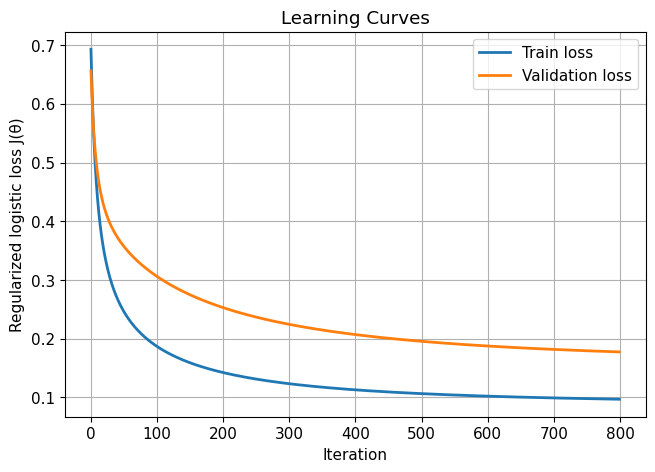

In [5]:
fig = plt.figure()
plt.plot(scratch.loss, label="Train loss", linewidth=2.0)
if np.any(scratch.val_loss):
    plt.plot(scratch.val_loss, label="Validation loss", linewidth=2.0)
plt.xlabel("Iteration")
plt.ylabel("Regularized logistic loss J(θ)")
plt.title("Learning Curves")
plt.legend()
plt.show()

## Problem 7 - Decision Region Visualization (2D)

We draw decision regions using **two features** to enable a 2D plot:
- **x-axis (horizontal): sepal width**
- **y-axis (vertical): petal length**

Approach: train a new model on **only these two standardized features**, then color the grid by predicted class.


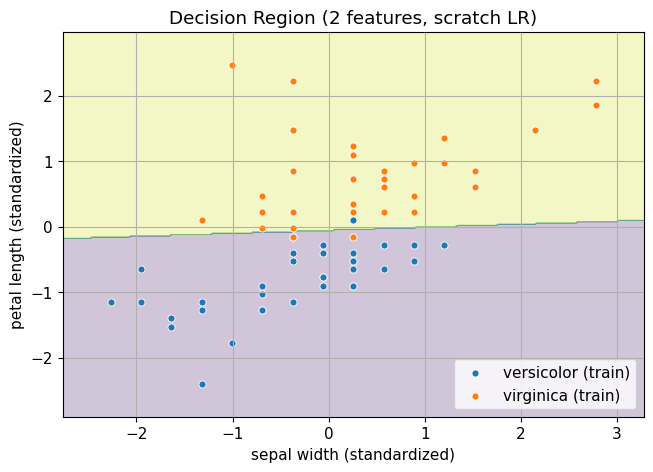

In [6]:
# Pick feature indices as requested: sepal width (1) and petal length (2) in Iris order
# If fallback synthetic data is used, we have named columns accordingly.
def select_2d_features(X, names):
    # Try to find matching names (sklearn iris names)
    ix_sw = None
    ix_pl = None
    for i, n in enumerate(names):
        if "sepal width" in n:
            ix_sw = i
        if "petal length" in n:
            ix_pl = i
    # If not found, default to the first two columns
    if ix_sw is None or ix_pl is None:
        ix_sw, ix_pl = 0, 1
    return ix_sw, ix_pl

ix_sw, ix_pl = select_2d_features(X_all, feature_names)

# Build 2D datasets
X2_tr = X_train[:, [ix_sw, ix_pl]]
X2_va = X_val[:, [ix_sw, ix_pl]]

# Standardize 2D
sc2 = StandardScaler()
X2_tr_std = sc2.fit_transform(X2_tr)
X2_va_std = sc2.transform(X2_va)

# Train a fresh 2D model
model2d = ScratchLogisticRegression(num_iter=800, lr=0.1, reg_lambda=0.1, use_bias=True, verbose=False)
model2d.fit(X2_tr_std, y_train, X_val=X2_va_std, y_val=y_val)

# Create meshgrid
x_min, x_max = X2_tr_std[:,0].min()-0.5, X2_tr_std[:,0].max()+0.5
y_min, y_max = X2_tr_std[:,1].min()-0.5, X2_tr_std[:,1].max()+0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = model2d.predict(grid).reshape(xx.shape)

# Plot decision region
fig = plt.figure()
plt.contourf(xx, yy, Z, alpha=0.25)   # region
# Overlay training points
plt.scatter(X2_tr_std[y_train==0,0], X2_tr_std[y_train==0,1], s=26, edgecolor="white", linewidth=0.6, label="versicolor (train)")
plt.scatter(X2_tr_std[y_train==1,0], X2_tr_std[y_train==1,1], s=26, edgecolor="white", linewidth=0.6, label="virginica (train)")
plt.xlabel("sepal width (standardized)")
plt.ylabel("petal length (standardized)")
plt.title("Decision Region (2 features, scratch LR)")
plt.legend()
plt.show()

## Problem 8 - Saving & Loading Weights

We save learned parameters with `np.savez` and show that a fresh model with loaded weights produces identical predictions.

In [8]:
save_path = "/content/sample_data/logreg_weights.npz" # path
scratch.save_weights(save_path)

theta_loaded, meta = ScratchLogisticRegression.load_weights(save_path)
restored = ScratchLogisticRegression(num_iter=1, lr=meta["lr"], reg_lambda=meta["reg_lambda"], use_bias=meta["use_bias"])
# Initialize and assign loaded parameters
restored._init_params(len(theta_loaded))
restored.theta_ = theta_loaded.copy()

# Check predictions match
pred_restored = restored.predict(X_val_std)
print("Weights saved to:", save_path)
print("Restored-meta:", meta)
print("Predictions equal:", np.array_equal(pred_restored, pred_val))

Weights saved to: /content/sample_data/logreg_weights.npz
Restored-meta: {'use_bias': True, 'lr': 0.1, 'num_iter': 800, 'reg_lambda': 0.1}
Predictions equal: True



---

## Conclusion

You now have a full **scratch** logistic regression with:
- All problems tackled
- Enjoyed this challenge!

Feel free to tweak `reg_lambda`, iterations, or threshold to explore bias/variance effects.
